In [1]:
import itertools
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.spatial import Delaunay

In [2]:
cube2d = np.array(list(itertools.product([1, -1], repeat=2)))
cube3d = np.array(list(itertools.product([1, -1], repeat=3)))
cube4d = np.array(list(itertools.product([1, -1], repeat=4)))

for cube in [cube2d, cube3d, cube4d]:
    print(f'Dimension: {cube.shape[1]}; Vertices: {cube.shape[0]}')

Dimension: 2; Vertices: 4
Dimension: 3; Vertices: 8
Dimension: 4; Vertices: 16


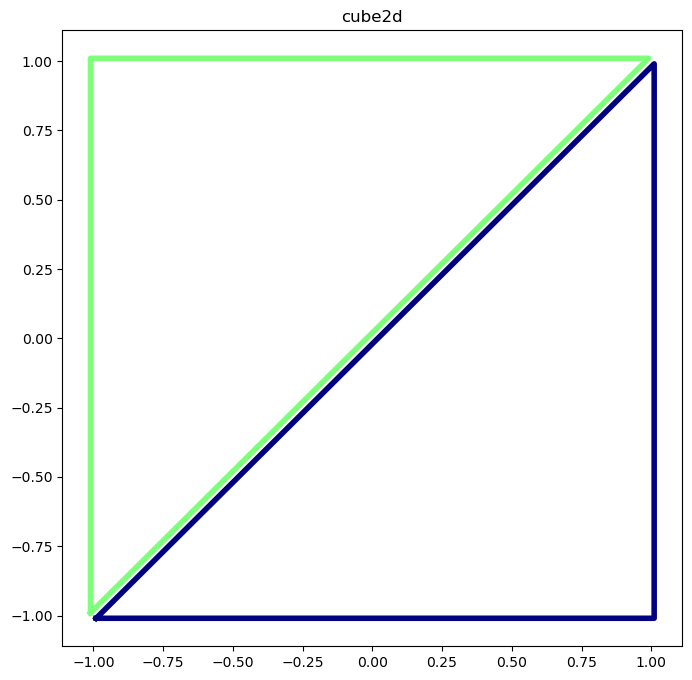

In [3]:
cmap = cm.jet
eps = 0.03

cube = cube2d
title = f'cube{cube.shape[1]}d'

tri = Delaunay(cube)
simplices = np.array([cube[simplex] for simplex in tri.simplices])
centers = np.array([simplex.mean(axis=0) for simplex in simplices])
moves = eps*centers
colors = [cmap(i/len(simplices)) for i in range(len(simplices))]

plt.figure(figsize=(8, 8))
plt.title(title)
for i in range(len(simplices)):
    simplex = simplices[i] + moves[i]
    color = colors[i]
    x = np.append(simplex[:, 0], simplex[0, 0])
    y = np.append(simplex[:, 1], simplex[0, 1])
    plt.plot(x, y, color=color, linewidth=4)

<IPython.core.display.Javascript object>


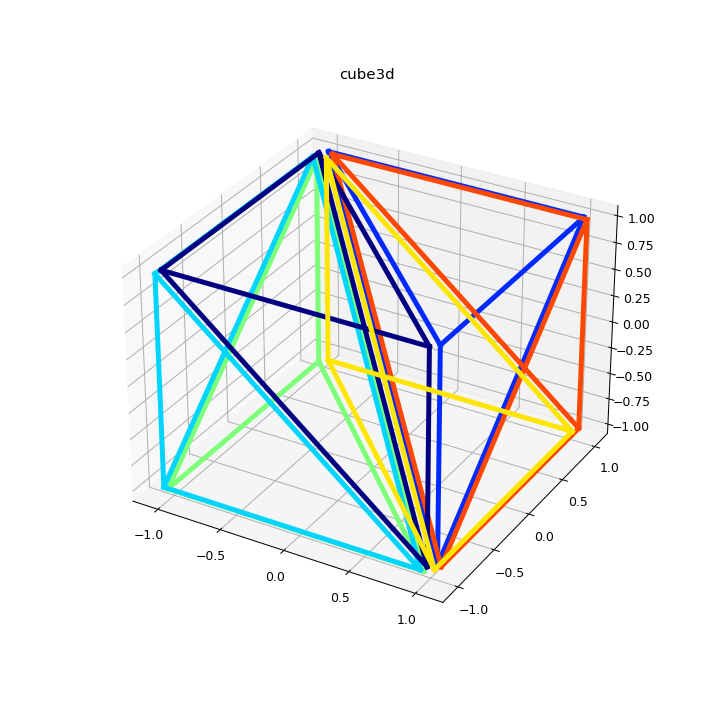

In [4]:
%matplotlib notebook
cmap = cm.jet
eps = 0.1

cube = cube3d
title = f'cube{cube.shape[1]}d'

tri = Delaunay(cube)
simplices = np.array([cube[simplex] for simplex in tri.simplices])
centers = np.array([simplex.mean(axis=0) for simplex in simplices])
moves = eps*centers
colors = [cmap(i/len(simplices)) for i in range(len(simplices))]
np.random.shuffle(colors)

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
ax.set_title(title)

for i in range(len(simplices)):
    simplex = simplices[i] + moves[i]
    color = colors[i]
    for edge in itertools.combinations(simplex, 2):
        xyz = np.array(edge)
        ax.plot3D(xyz[:, 0], xyz[:, 1], xyz[:, 2], color=color, linewidth=4)

In [5]:
truncated_octahedron = np.array(list(itertools.permutations([0, 1, 2], 3)))
truncated_octahedron = np.concatenate([truncated_octahedron*np.array(i) for i in itertools.product([1, -1], repeat=3)])
truncated_octahedron = 0.5*np.unique(truncated_octahedron, axis=0)
truncated_octahedron

array([[-1. , -0.5,  0. ],
       [-1. ,  0. , -0.5],
       [-1. ,  0. ,  0.5],
       [-1. ,  0.5,  0. ],
       [-0.5, -1. ,  0. ],
       [-0.5,  0. , -1. ],
       [-0.5,  0. ,  1. ],
       [-0.5,  1. ,  0. ],
       [ 0. , -1. , -0.5],
       [ 0. , -1. ,  0.5],
       [ 0. , -0.5, -1. ],
       [ 0. , -0.5,  1. ],
       [ 0. ,  0.5, -1. ],
       [ 0. ,  0.5,  1. ],
       [ 0. ,  1. , -0.5],
       [ 0. ,  1. ,  0.5],
       [ 0.5, -1. ,  0. ],
       [ 0.5,  0. , -1. ],
       [ 0.5,  0. ,  1. ],
       [ 0.5,  1. ,  0. ],
       [ 1. , -0.5,  0. ],
       [ 1. ,  0. , -0.5],
       [ 1. ,  0. ,  0.5],
       [ 1. ,  0.5,  0. ]])

<IPython.core.display.Javascript object>


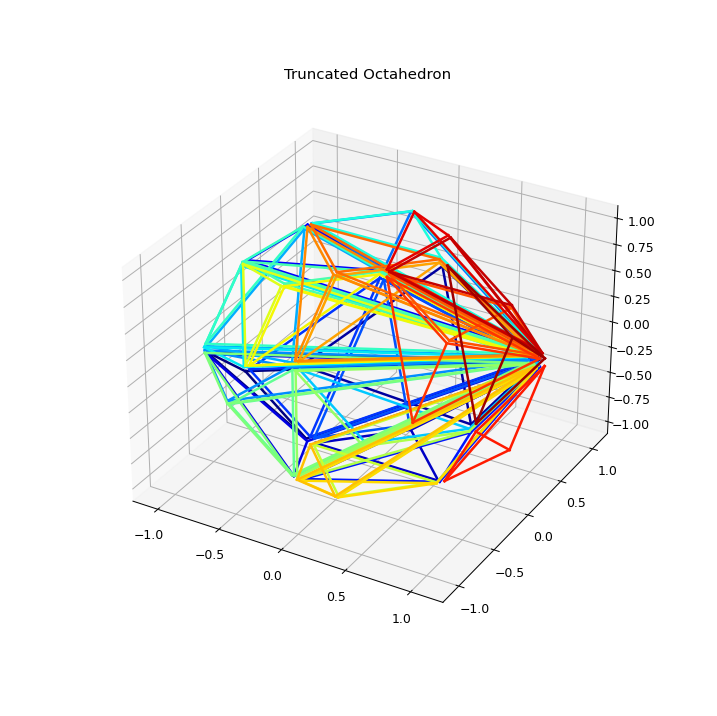

In [6]:
%matplotlib notebook
cmap = cm.jet
eps = 0.1

figure = truncated_octahedron
title = 'Truncated Octahedron'

tri = Delaunay(figure)
simplices = np.array([figure[simplex] for simplex in tri.simplices])
centers = np.array([simplex.mean(axis=0) for simplex in simplices])
moves = eps*centers
colors = [cmap(i/len(simplices)) for i in range(len(simplices))]
#np.random.shuffle(colors)

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
ax.set_title(title)

for i in range(len(simplices)):
    simplex = simplices[i] + moves[i]
    color = colors[i]
    for edge in itertools.combinations(simplex, 2):
        xyz = np.array(edge)
        ax.plot3D(xyz[:, 0], xyz[:, 1], xyz[:, 2], color=color, linewidth=2)

# Half triangulation

В общем, я набросал алгоритм триангуляции правильного или полуправильного многогранника размерности $d$, удовлетворяющей тому, чтобы противоположные стороны стакались.

Суть такова:
1. Найти все гиперплоскости размерности $d-1$ используя `get_hyperspaces`
2. Выбрать какую-нибудь из гиперплоскостей, содержащих максимальное количество точек данного многогранника, и содержащих 0
3. Для выбронной гиперплоскости найти положительнонаправленный вектор нормали с помощью `get_normal`
4. Выбрать все неотрицательноопределённые относительно гиперплоскости точки многогранника
5. Для этих точек найти симплексы, используя `scipy.spatial.Delaunay` - это половина всех симплексов
6. Отразить эту половину симплксов относительно вектора нормали с помощью `reflect_simplices`

In [7]:
def sets_in_hyperspace(set0, set1, eps=10**-6):
    # returns True if sets are in 1 hyperspace
    g = True
    for vector in set1:
        matrix = np.array(set0)
        matrix -= vector
        # np.linalg.det can be not accurate, so I use eps instead zero
        if abs(np.linalg.det(matrix)) >= eps:
            g = False
            break
    return g

In [8]:
def get_hyperspaces(points):
    # returns lists of all hyperspaces containing point sets
    dim = points.shape[-1]
    if len(points) < dim + 1:
        raise ValueError(f"The number of points less then {dim}-dimensional simplex size")
    spaces = []
    for simplex in itertools.combinations(np.arange(len(points)), dim):
        simplex_points = points[np.array(simplex)]
        g = True
        for space_id in range(len(spaces)):
            space_simplex = np.array(spaces[space_id][0])
            space_points = points[space_simplex]
            # Условие, что space_points и simplex_points из одной гиперплоскости
            if sets_in_hyperspace(simplex_points, space_points):
                spaces[space_id].append(simplex)
                g = False
        if g:
            spaces.append([simplex])
    for space_id in range(len(spaces)):
        spaces[space_id] = np.unique(spaces[space_id])
    return spaces

In [9]:
cube2d_hyperspaces = get_hyperspaces(cube2d)

print(f'Got {len(cube2d_hyperspaces)} hyperspaces')
print(f'The number of points in hyperspace can be {np.unique([len(i) for i in cube2d_hyperspaces])}\n')

for length in np.unique([len(i) for i in cube2d_hyperspaces]):
    cnt = (np.array([len(i) for i in cube2d_hyperspaces]) == length).sum()
    print(f"Hyperspaces length {length}: {cnt}")

Got 6 hyperspaces
The number of points in hyperspace can be [2]

Hyperspaces length 2: 6


In [10]:
cube3d_hyperspaces = get_hyperspaces(cube3d)

print(f'Got {len(cube3d_hyperspaces)} hyperspaces')
print(f'The number of points in hyperspace can be {np.unique([len(i) for i in cube3d_hyperspaces])}\n')

for length in np.unique([len(i) for i in cube3d_hyperspaces]):
    cnt = (np.array([len(i) for i in cube3d_hyperspaces]) == length).sum()
    print(f"Hyperspaces length {length}: {cnt}")

Got 20 hyperspaces
The number of points in hyperspace can be [3 4]

Hyperspaces length 3: 8
Hyperspaces length 4: 12


In [11]:
to_hyperspaces = get_hyperspaces(truncated_octahedron)

print(f'Got {len(to_hyperspaces)} hyperspaces')
print(f'The number of points in hyperspace can be {np.unique([len(i) for i in to_hyperspaces])}\n')

for length in np.unique([len(i) for i in to_hyperspaces]):
    cnt = (np.array([len(i) for i in to_hyperspaces]) == length).sum()
    print(f"Hyperspaces length {length}: {cnt}")

Got 679 hyperspaces
The number of points in hyperspace can be [3 4 6 8]

Hyperspaces length 3: 432
Hyperspaces length 4: 216
Hyperspaces length 6: 28
Hyperspaces length 8: 3


<IPython.core.display.Javascript object>


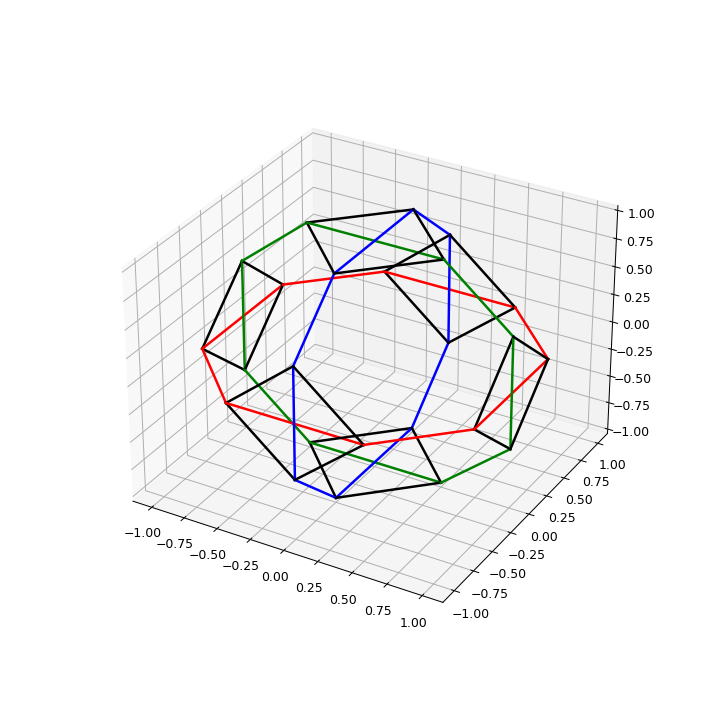

In [12]:
to_hyperspaces8 = [to_hyperspaces[i] for i in np.where(np.array([len(i) for i in to_hyperspaces]) == 8)[0]]
colors = ['red', 'green', 'blue']


ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')

for i, j in itertools.combinations(np.arange(len(truncated_octahedron)), 2):
    color = 'black'
    for k in range(3):
        if (i in to_hyperspaces8[k]) and (j in to_hyperspaces8[k]):
            color = colors[k]
    edge = np.array([truncated_octahedron[i], 
                     truncated_octahedron[j]])
    edge_length = np.linalg.norm(edge[0] - edge[1])
    if edge_length < 1.2:
        ax.plot3D(edge[:, 0], edge[:, 1], edge[:, 2], color=color, linewidth=2)

In [13]:
hyperspace_set = truncated_octahedron[to_hyperspaces8[0][:3]]

truncated_octahedron_half = np.array([np.linalg.det(hyperspace_set - point) for point in truncated_octahedron]) >= 0
truncated_octahedron_half = truncated_octahedron[truncated_octahedron_half]
truncated_octahedron_half

array([[-1. , -0.5,  0. ],
       [-1. ,  0. ,  0.5],
       [-1. ,  0.5,  0. ],
       [-0.5, -1. ,  0. ],
       [-0.5,  0. ,  1. ],
       [-0.5,  1. ,  0. ],
       [ 0. , -1. ,  0.5],
       [ 0. , -0.5,  1. ],
       [ 0. ,  0.5,  1. ],
       [ 0. ,  1. ,  0.5],
       [ 0.5, -1. ,  0. ],
       [ 0.5,  0. ,  1. ],
       [ 0.5,  1. ,  0. ],
       [ 1. , -0.5,  0. ],
       [ 1. ,  0. ,  0.5],
       [ 1. ,  0.5,  0. ]])

<IPython.core.display.Javascript object>


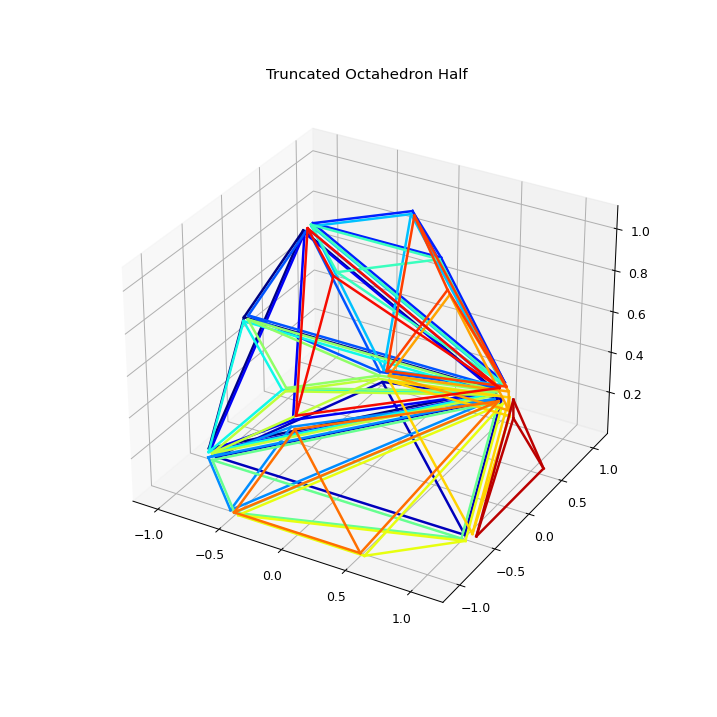

In [14]:
%matplotlib notebook
cmap = cm.jet
eps = 0.1

figure = truncated_octahedron_half
title = 'Truncated Octahedron Half'

tri = Delaunay(figure)
simplices = np.array([figure[simplex] for simplex in tri.simplices])
centers = np.array([simplex.mean(axis=0) for simplex in simplices])
moves = eps*centers
colors = [cmap(i/len(simplices)) for i in range(len(simplices))]
#np.random.shuffle(colors)

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
ax.set_title(title)

for i in range(len(simplices)):
    simplex = simplices[i] + moves[i]
    color = colors[i]
    for edge in itertools.combinations(simplex, 2):
        xyz = np.array(edge)
        ax.plot3D(xyz[:, 0], xyz[:, 1], xyz[:, 2], color=color, linewidth=2)
        
print('')

In [15]:
def get_normal(points):
    # returns normal of d-dimensional hyperspace using d+1 given points dim d+1
    basis = points[1:] - points[0]
    normal = np.linalg.solve(np.concatenate([basis, np.random.random(size=[1, basis.shape[1]])]), np.append(np.zeros(len(basis)), 1))
    normal = normal / np.linalg.norm(normal)
    if np.linalg.det(points - normal) < 0:
        normal *= -1
    return normal

In [16]:
def reflect(points, vector):
    # 
    coeff = 2 * np.dot(points, vector) / np.dot(vector, vector)
    new_points = points - vector.reshape([1, len(vector)])*coeff.reshape(len(coeff), 1)
    return new_points

In [17]:
print(truncated_octahedron_half, '\n')

normal = np.round(get_normal(hyperspace_set), 6)
print(normal)

reflect(truncated_octahedron_half, normal)

[[-1.  -0.5  0. ]
 [-1.   0.   0.5]
 [-1.   0.5  0. ]
 [-0.5 -1.   0. ]
 [-0.5  0.   1. ]
 [-0.5  1.   0. ]
 [ 0.  -1.   0.5]
 [ 0.  -0.5  1. ]
 [ 0.   0.5  1. ]
 [ 0.   1.   0.5]
 [ 0.5 -1.   0. ]
 [ 0.5  0.   1. ]
 [ 0.5  1.   0. ]
 [ 1.  -0.5  0. ]
 [ 1.   0.   0.5]
 [ 1.   0.5  0. ]] 

[0. 0. 1.]


array([[-1. , -0.5,  0. ],
       [-1. ,  0. , -0.5],
       [-1. ,  0.5,  0. ],
       [-0.5, -1. ,  0. ],
       [-0.5,  0. , -1. ],
       [-0.5,  1. ,  0. ],
       [ 0. , -1. , -0.5],
       [ 0. , -0.5, -1. ],
       [ 0. ,  0.5, -1. ],
       [ 0. ,  1. , -0.5],
       [ 0.5, -1. ,  0. ],
       [ 0.5,  0. , -1. ],
       [ 0.5,  1. ,  0. ],
       [ 1. , -0.5,  0. ],
       [ 1. ,  0. , -0.5],
       [ 1. ,  0.5,  0. ]])

In [18]:
def reflect_simplices(simplices, vector):
    # 
    new_simplices = []
    for simplex in simplices:
        new_simplices.append(reflect(simplex, vector))
    return np.array(new_simplices)

<IPython.core.display.Javascript object>


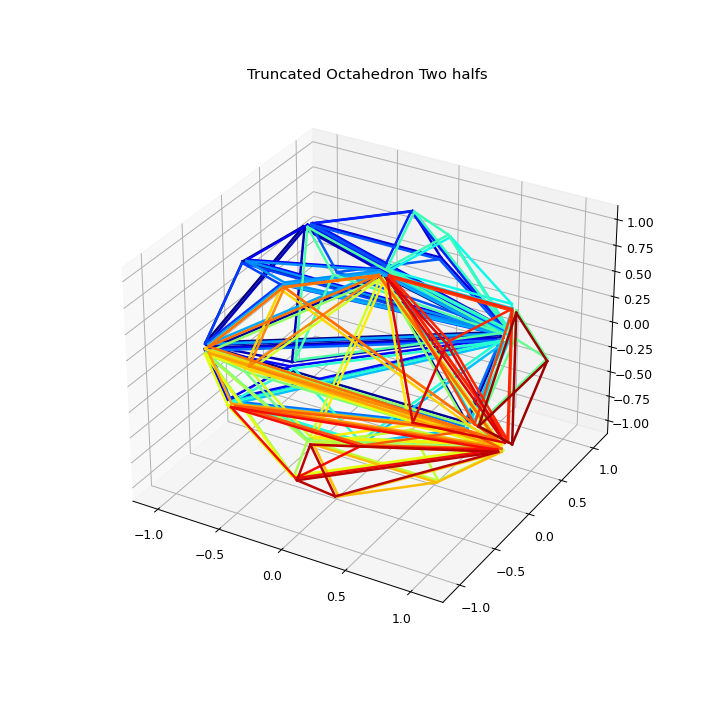

In [19]:
%matplotlib notebook
cmap = cm.jet
eps = 0.1

figure = truncated_octahedron_half
title = 'Truncated Octahedron Two halfs'

tri = Delaunay(figure)
simplices = np.array([figure[simplex] for simplex in tri.simplices])

normal = np.round(get_normal(hyperspace_set), 6)
simplices = np.concatenate([simplices, reflect_simplices(simplices, normal)])


centers = np.array([simplex.mean(axis=0) for simplex in simplices])
moves = eps*centers
colors = [cmap(i/len(simplices)) for i in range(len(simplices))]
#np.random.shuffle(colors)

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
ax.set_title(title)

for i in range(len(simplices)):
    simplex = simplices[i] + moves[i]
    color = colors[i]
    for edge in itertools.combinations(simplex, 2):
        xyz = np.array(edge)
        ax.plot3D(xyz[:, 0], xyz[:, 1], xyz[:, 2], color=color, linewidth=2)